## Reload the `EC_estimator.py` code to consider any changes

In [2]:
#reload model magic
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


import EC_estimator as annec

In [4]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tabulate import tabulate
import EC_estimator as annec
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import Model

In [5]:
tf.__version__

'2.2.0'

In [9]:
def create_antecedent_inputs_ordered(
    df_inputs: pd.DataFrame,
    ndays: int = 8,          # will create 1d..7d (since 0d is the original column)
    window_size: int = 11,
    nwindows: int = 10,      # will create 1ave..10ave
    predictors_order=None,
    date_col: str = "date",
):
    
    # --- set predictor order
    if predictors_order is None:
        predictors_order = df_inputs.columns.tolist()

    # --- require DatetimeIndex for the time-based rolling/shifts
    if not isinstance(df_inputs.index, pd.DatetimeIndex):
        raise ValueError("df_inputs must have a DatetimeIndex (set date as index first).")

    df_inputs = df_inputs.sort_index()

    out = pd.DataFrame(index=df_inputs.index)

    # 1) date column first (as a column, not index)
    out[date_col] = df_inputs.index

    # 2) original predictors next
    for p in predictors_order:
        out[p] = df_inputs[p]

    # 3) daily antecedents grouped by lag: 1d..(ndays-1)d
    for d in range(1, ndays):
        for p in predictors_order:
            out[f"{p}_{d}d"] = df_inputs[p].shift(d)

    # 4) rolling averages grouped by window number: 1ave..nwindows_ave
    # Rolling mean over a time window (requires daily-ish datetime index)
    for p in predictors_order:
        out[f"__tmp_ma__{p}"] = df_inputs[p].rolling(f"{window_size}D", min_periods=window_size).mean()

    for k in range(1, nwindows + 1):
        shift_days = ndays + window_size * (k - 1)
        for p in predictors_order:
            out[f"{p}_{k}ave"] = out[f"__tmp_ma__{p}"].shift(shift_days, freq="D")

    # remove temp columns
    out = out.drop(columns=[f"__tmp_ma__{p}" for p in predictors_order])

    # drop rows that are incomplete due to shifting/rolling
    out = out.dropna().reset_index(drop=True)

    return out


In [12]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

in_path = './Inputs/EC_inputs.csv'
df = pd.read_csv(in_path)

# parse/sort/index
df["date"] = pd.to_datetime(df["date"], errors="raise")
df = df.sort_values("date").set_index("date")

predictors = ["dcc","exports","sac","sjr","tide","net_dcd", "smscg"]
y_col = "EC"
# X for antecedents (no output inside)
X = df[predictors].copy()

ante = create_antecedent_inputs_ordered(
    X,
    ndays=8,
    window_size=11,
    nwindows=10,
    predictors_order=predictors,
    date_col="date",
)

# --- add output as last column by matching date
# 'ante' currently has a 'date' column (not index), so merge on that
y = df[[y_col]].reset_index()  # columns: date, X_2_DIS
ante = ante.merge(y, on="date", how="left")

# (optional) sanity check: make sure nothing is missing
missing_y = ante[y_col].isna().sum()
if missing_y:
    raise ValueError(f"{missing_y} rows have missing {y_col} after merge. Check date alignment.")

# write
out_path = "./Inputs/EC_inputs_antecedents_ordered_with_output.csv"
ante.to_csv(out_path, index=False)
print("Saved:", out_path)


Saved: ./Inputs/EC_inputs_antecedents_ordered_with_output.csv


## Load the dataset, preprocessing, and apply ANN model

In [13]:
# Load data
df = annec.load_data('Inputs/EC_inputs_antecedents_ordered_with_output.csv')
df_var = annec.df_by_variable(df)



# Split data
train_rows = df_var.shape[0] - 6039
df_train, df_test = annec.split_data(df_var, train_rows, 6039)

# Build model inputs
inputs = annec.build_model_inputs(df_var)

# Preprocessing layers
layers = annec.preprocessing_layers(df_var, inputs)

# Build model
neurons = [8, 2, 1]  # This is an example; adapt it to your needs
activations = ['sigmoid', 'sigmoid']
model, tensorboard_cb = annec.build_model(layers, inputs)


X_train = [ df_train.loc[:, pd.IndexSlice[feature,annec.lags_feature[feature]]] for feature in annec.feature_names()]

y_train = df_train[('EC','0d')].to_frame()  # situation where one column is produced and coerced to a series
# Otherwise you would do something like:
#y.droplevel(level='lag',axis=1).rename(mapper={"EC":"emm_ec"})
y_train.columns = ["emm_ec"]



X_test = [ df_test.loc[:, pd.IndexSlice[feature,annec.lags_feature[feature]]] for feature in annec.feature_names()]


y_test = df_test[('EC','0d')].to_frame()  # Only works for univariate dataset where it is a series
y_test.columns = ["emm_ec"] 


# Train model
history, model = annec.train_model(model, tensorboard_cb, X_train, y_train, X_test, y_test)

In [15]:
# Load data
df = annec.load_data("Inputs/EC_inputs_antecedents_ordered_with_output.csv")
# Parse real dates
df["date"] = pd.to_datetime(df["date"], errors="raise")

# Sort and set REAL date index
df = df.sort_values("date").set_index("date")

# Remove date from columns so it is NOT treated as a feature
df = df.drop(columns=["date"], errors="ignore")


# Now create (var, lag) MultiIndex columns
df_var = annec.df_by_variable(df)



# Split by date ranges
# ----------------------------
# df_var likely has a MultiIndex columns and a datetime-like index
# Ensure index is datetime
if not isinstance(df_var.index, pd.DatetimeIndex):
    df_var.index = pd.to_datetime(df_var.index, errors="raise")

df_var = df_var.sort_index()

# Define date ranges
test_start  = "1923-01-01"
test_end    = "1939-12-31"
train_start = "1940-01-01"
train_end   = "2015-12-31"

df_test  = df_var.loc[test_start:test_end].copy()
df_train = df_var.loc[train_start:train_end].copy()

# Optional sanity checks
if df_test.empty:
    raise ValueError("df_test is empty. Check that the index is datetime and dates exist in 1923–1939.")
if df_train.empty:
    raise ValueError("df_train is empty. Check that the index is datetime and dates exist in 1940–2015.")

print("Train:", df_train.index.min().date(), "→", df_train.index.max().date(), "rows:", len(df_train))
print("Test :", df_test.index.min().date(),  "→", df_test.index.max().date(),  "rows:", len(df_test))

# Build model inputs
inputs = annec.build_model_inputs(df_var)

# Preprocessing layers
layers = annec.preprocessing_layers(df_var, inputs)

# Build model
neurons = [8, 2, 1]  # This is an example; adapt it to your needs
activations = ['sigmoid', 'sigmoid']
model, tensorboard_cb = annec.build_model(layers, inputs)


X_train = [ df_train.loc[:, pd.IndexSlice[feature,annec.lags_feature[feature]]] for feature in annec.feature_names()]

target = "EC"

y_train = df_train.loc[:, pd.IndexSlice[target, :]].iloc[:, 0].to_frame(name=target)
# Otherwise you would do something like:
#y.droplevel(level='lag',axis=1).rename(mapper={"EC":"emm_ec"})
y_train.columns = ["EC"]



X_test = [ df_test.loc[:, pd.IndexSlice[feature,annec.lags_feature[feature]]] for feature in annec.feature_names()]


y_test  = df_test.loc[:,  pd.IndexSlice[target, :]].iloc[:, 0].to_frame(name=target)
y_test.columns = ["EC"] 


# Train model
history, model = annec.train_model(model, tensorboard_cb, X_train, y_train, X_test, y_test)

Train: 1940-01-01 → 2015-09-29 rows: 27666
Test : 1923-08-23 → 1939-12-31 rows: 5975


## Evaluation of the model

In [16]:
# Calculate metrics for ANN
#print(model.summary())
metrics = []
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("predictions")
print(y_train_pred[-4:-1])
print(y_test_pred[-4:-1])
print("input data")
print(X_train[0].iloc[-4:-1])
print(X_test[0].iloc[-4:-1])
print("end predictions")
metrics.append(annec.calculate_metrics('ANN', y_train, y_train_pred, y_test, y_test_pred))

df3 = pd.DataFrame(metrics)

#print(tabulate(df3, headers='keys', tablefmt='psql'))



predictions
[[3235.6602]
 [3392.5686]
 [3591.2734]]
[[1182.2521]
 [1072.6012]
 [ 939.7073]]
input data
var                 sac                                                      \
lag                  0d           1d           2d           3d           4d   
date                                                                          
2015-09-26  7785.670076  7799.537119  7808.753521  7815.169612  7819.799191   
2015-09-27  7763.476647  7785.670076  7799.537119  7808.753521  7815.169612   
2015-09-28  7724.776026  7763.476647  7785.670076  7799.537119  7808.753521   

var                                                                          \
lag                  5d           6d           7d         1ave         2ave   
date                                                                          
2015-09-26  7823.235474  7825.844312  7827.861244  7833.139374  7798.669268   
2015-09-27  7819.799191  7823.235474  7825.844312  7832.484449  7807.586937   
2015-09-28  7815.169612  78

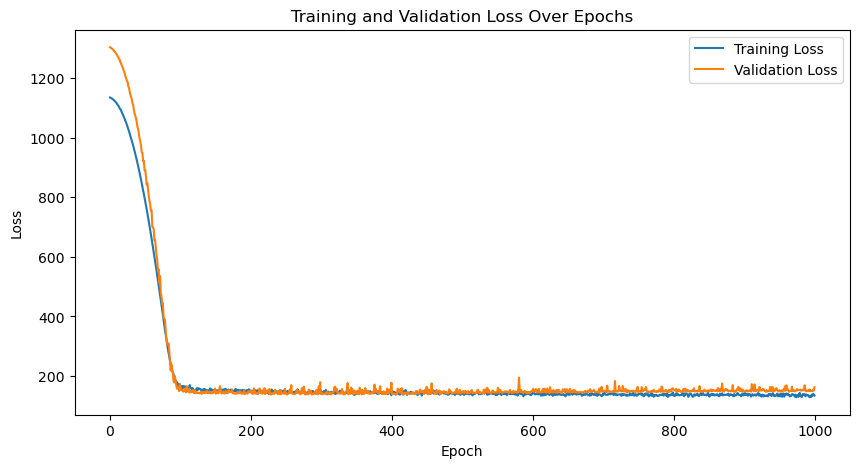

In [17]:
annec.plot_history(history)

## Plot the ANN prediction versus the test target as a time series

0    823.735229
Name: 1939-12-31 00:00:00, dtype: float32


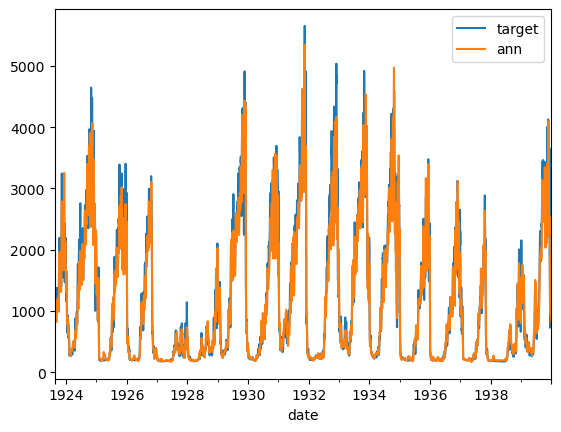

In [18]:
import matplotlib.pyplot as plt
ax = y_test.plot()
pred = pd.DataFrame(index=y_test.index,data= y_test_pred)
print(pred.iloc[-1])
pred.plot(ax=ax)
plt.legend(["target","ann"])

## Save the final model

In [19]:
############################################################################################
############# Please change the model_save_path to the direction you saved the files #######
############################################################################################

model_save_path = r'./Export/emmaton'
annec.save_model(model, model_save_path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./Export/emmaton\assets
Model saved at location: ./Export/emmaton


dd

In [20]:
def root_mean_squared_error(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))

loaded_model = tf.keras.models.load_model(model_save_path, custom_objects={'root_mean_squared_error': root_mean_squared_error})
# Calculate metrics for ANN
metrics = []
y_train_pred = loaded_model.predict(X_train)
y_test_pred = loaded_model.predict(X_test)
metrics.append(annec.calculate_metrics('ANN', y_train, y_train_pred, y_test, y_test_pred))

df3 = pd.DataFrame(metrics)
print(tabulate(df3, headers='keys', tablefmt='psql'))


+----+---------+------------+--------------+-------------------------+-----------+-------------+------------------------+
|    | Model   |   Train_R2 |   Train_RMSE |   Train_Percentage_Bias |   Test_R2 |   Test_RMSE |   Test_Percentage_Bias |
|----+---------+------------+--------------+-------------------------+-----------+-------------+------------------------|
|  0 | ANN     |       0.98 |       110.95 |                     0.6 |      0.97 |      196.49 |                   -0.2 |
+----+---------+------------+--------------+-------------------------+-----------+-------------+------------------------+


## Load the saved model and test it with dataset and one sample

Currently this tests Emmaton at a time when EC is 200-ish which is not a very compelling example. It also appears to use the same inputs as the test/training process, so the above example should cover it.

In [ ]:
def root_mean_squared_error(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))

loaded_model = tf.keras.models.load_model(model_save_path, custom_objects={'root_mean_squared_error': root_mean_squared_error})
# Calculate metrics for 

df_sample = pd.read_csv("F:/projects/ann_calsim_ec_estimator/Inputs/selected.csv", header=None)
input_sample = [frame.to_frame().to_numpy().transpose() for ndx,frame in df_sample.iterrows()] 
print("Sample")
print(input_sample)
y_sample_pred = loaded_model.predict(input_sample)
print(y_sample_pred)



